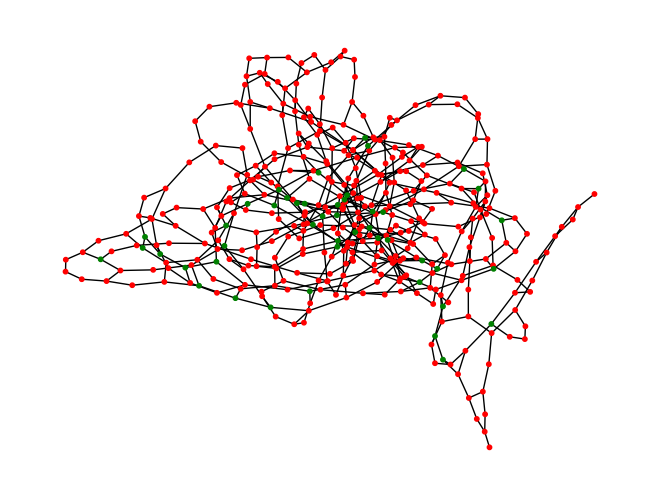

In [1]:
from Partition import *
from Fusion import *
from Graph_State import *

NQubit = 4
Depth = 200
MaxDegree = 3

def to_undirected(gs):
    undirected_graph = nx.Graph()
    for nnode in gs.nodes():
        undirected_graph.add_node(nnode)
        undirected_graph.nodes[nnode]['layer'] = gs.nodes[nnode]['layer']
    for edge in gs.edges():
        if edge not in undirected_graph.edges():
            undirected_graph.add_edge(edge[0], edge[1])
    return undirected_graph



def main():
    gs, input_nodes, colors = generate_graph_state(NQubit, Depth)
    gs = partition(gs, input_nodes)
    undirected_graph = to_undirected(gs)
    fgraph, added_nodes = fusion_graph(undirected_graph, MaxDegree)
    # labels = nx.get_node_attributes(gs, 'layer')
    # node_pos = nx.get_node_attributes(gs, 'pos')
    # nx.draw(gs, pos = node_pos, node_color = colors, node_size = 10, labels = labels,  font_size=5)
    # print(labels)
    return

if __name__ == '__main__':
    main()